In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
from __future__ import annotations
import networkx as nx
import jaxley as jx
from jaxley.io.swc import read_swc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# TODOS:

### change order of nodes and edges
- Nodes: idx, indices (int), groups (bool), morph_attrs, channel_attrs, other_attrs (set_by)
- Edges: idx, indices (int), synapses (bool), morph_attrs, channel_attrs, other_attrs (set_by)

### Reformat dataframes
- rename `global_X_index` to `X_index`
- use tuples of nodes to index edges
- treat synapses like groups and channels, i.e. boolean indices

### Pass tests
- pass import / export cycle tests
- pass `test_swc.py`

### Remove group_names from global graph attrs
- group_names can be inferred from nodes, i.e. names of boolean cols which are not channels.


### Keep branchpoints and tip nodes in `nodes` and in graph
- introduce `compartments` attribute that only shows compartment nodes? Nodes shows all nodes `cell.nodes.loc[is_comp]`

### Refactor graph editing functions in `morph_utils`
- with the new graph functionality, this should be much easier to do

### Refactor `compute_xyz` function
- replace old `compute_xyz` with new version

### Refactor `set_ncomp`
- `set_ncomp` should be much simpler via `branch_comps_from_nodes`

In [4]:
from jaxley.io.graph import to_swc_graph, build_compartment_graph, _remove_branch_points_at_tips, _set_comp_and_branch_index, _remove_branch_points, _add_meta_data, nx_to_pandas
import pickle

# SAVE GRAPHS FROM OLD READER
# fname = "morph_ca1_n120"
# swc_graph = to_swc_graph(f"../jaxley/tests/swc_files/{fname}.swc")

# comp_graph = build_compartment_graph(swc_graph, ncomp=1, ignore_swc_tracing_interruptions=False, max_len=2000.0)
# with open(f"{fname}_comp_graph_wo_metadata.pkl", "wb") as f:
#     pickle.dump(comp_graph, f)

# comp_graph = _remove_branch_points_at_tips(comp_graph)
# with open(f"{fname}_comp_graph_wo_branchpoints.pkl", "wb") as f:
#     pickle.dump(comp_graph, f)

# comp_graph = _set_comp_and_branch_index(comp_graph)
# with open(f"{fname}_comp_graph_w_comp_and_branch_index.pkl", "wb") as f:
#     pickle.dump(comp_graph, f)

# solve_graph = _remove_branch_points(comp_graph)
# with open(f"{fname}_solve_graph_wo_branchpoints.pkl", "wb") as f:
#     pickle.dump(solve_graph, f)

# solve_graph = _add_meta_data(solve_graph)
# with open(f"{fname}_solve_graph_w_metadata.pkl", "wb") as f:
#     pickle.dump(solve_graph, f)


# LOAD SAVED GRAPHS FROM OLD READER
fname = "morph_ca1_n120"
with open(f"{fname}_comp_graph_wo_metadata.pkl", "rb") as f:
    jx_comp_graph = pickle.load(f)

with open(f"{fname}_comp_graph_wo_branchpoints.pkl", "rb") as f:
    jx_comp_graph = pickle.load(f)

with open(f"{fname}_comp_graph_w_comp_and_branch_index.pkl", "rb") as f:
    jx_comp_graph = pickle.load(f)

with open(f"{fname}_solve_graph_wo_branchpoints.pkl", "rb") as f:
    jx_comp_graph = pickle.load(f)

with open(f"{fname}_solve_graph_w_metadata.pkl", "rb") as f:
    jx_comp_graph = pickle.load(f)

jx_nodes_df, jx_edges_df, jx_global_attrs = nx_to_pandas(jx_comp_graph)

In [157]:
from jaxley.io.graph import swc_to_nx, build_compartment_graph, nx_to_pandas, _add_jaxley_meta_data, _replace_branchpoints_with_edges, _build_module, from_graph, pandas_to_nx, vis_compartment_graph, _set_graph_direction, _replace_branchpoints_with_edges, _replace_edges_with_branchpoints
import pandas as pd

swc_graph = swc_to_nx("../jaxley/tests/swc_files/morph_ca1_n120.swc")
comp_graph = build_compartment_graph(swc_graph, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph = _add_jaxley_meta_data(comp_graph)
comp_graph = _set_graph_direction(comp_graph)
comp_graph = _replace_branchpoints_with_edges(comp_graph)
# comp_graph = _replace_edges_with_branchpoints(comp_graph)
# nx_to_pandas(comp_graph)[0]

cell = _build_module(comp_graph)

In [158]:
def to_graph(module):
    # TODO: remove glue code
    edges = module.edges.set_index(["pre_index", "post_index"])
    edges.index.names = (None, None)

    G = pandas_to_nx(module.nodes, edges, pd.Series())

    global_attrs = ["xyzr", "channels", "synapses", "group_names", "branch_points_and_tips"]
    for attr in global_attrs:
        G.graph[attr] = getattr(module, attr)

    # G = _replace_edges_with_branchpoints(G) # TODO: fix this
    return G

def set_ncomp(view, ncomp):
    from jaxley.io.graph import branch_comps_from_nodes

    new_branch_comps = []
    for branch_idx in view._branches_in_view:
        branch = view.branch(branch_idx)
        node_attrs = pd.DataFrame(branch.xyzr[0], columns=["x", "y", "z", "r"])
        node_attrs["id"] = 0
        new_comps = branch_comps_from_nodes(node_attrs, ncomp)
        comp_cols = ["is_comp","id", "length", "x", "y", "z", "radius", "area", "volume"]
        comp_df = pd.DataFrame(new_comps, columns=comp_cols)
        comp_df = comp_df.loc[comp_df["is_comp"].astype(bool)].drop(columns=["id", "is_comp"])
        
        for name, is_group in branch.nodes[branch.group_names].all().items():
            comp_df.loc[:, name] = is_group

        comp_df["global_cell_index"] = branch.nodes["global_cell_index"].iloc[0]
        comp_df["global_branch_index"] = branch.nodes["global_branch_index"].iloc[0]
        comp_df["v"] = np.mean(branch.nodes["v"])
        comp_df["axial_resistivity"] = np.mean(branch.nodes["axial_resistivity"])
        comp_df["capacitance"] = np.mean(branch.nodes["capacitance"])
            
        comp_df.index = [-1]*len(comp_df.index)

        new_branch_comps.append(comp_df)

    for branch_idx, branch_comps in zip(view._branches_in_view, new_branch_comps):
        branch_nodes = view.nodes[view.nodes["global_branch_index"] == branch_idx].index
        view.base.nodes = pd.concat([view.base.nodes.loc[:branch_nodes[0]], branch_comps, view.base.nodes.loc[branch_nodes[-1]:]], ignore_index=True, join="outer")
    
    view.base.nodes["global_comp_index"] = np.arange(len(view.base.nodes))
    view.base._init_view()
    view.base._update_local_indices()
    

set_ncomp(cell.branch(0), 5)

In [159]:
cell.branch(0)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [28]:
# add option for different ncomp per branch in reader

old
       length    radius         x         y          z   groups
17   8.321000  7.914674 -1.431914  3.886156   0.000000   [soma]
18  60.357393  1.009666 -3.381243  8.867996  30.105249  [basal] 


new
       length    radius         x         y          z   soma  basal  apical
66   8.321000  7.939900 -1.431914  3.886156   0.000000   True  False   False
70  60.357393  2.521658 -3.381243  8.867996  30.105249  False   True   False


(-10.0, 15.0)

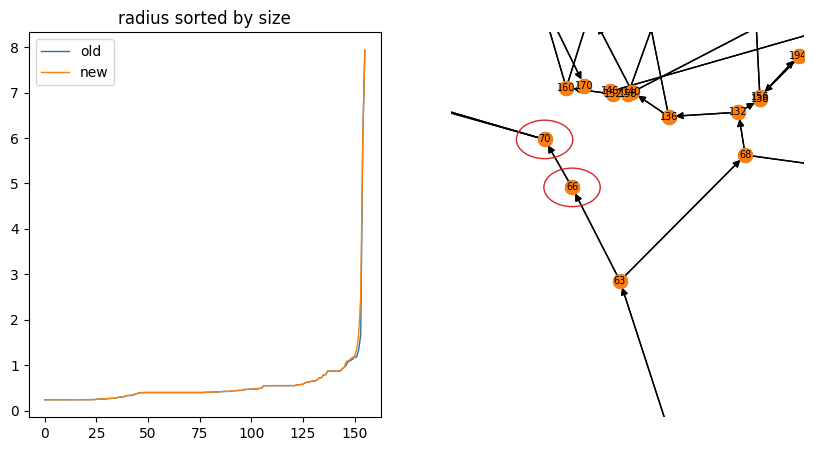

In [34]:
key = "radius"
nx_nodes_df = nx_to_pandas(comp_graph)[0]
nx_vals = nx_nodes_df[key]
jx_vals = jx_nodes_df[key]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(jx_vals.sort_values().values, label="old", lw=1)
ax[0].plot(nx_vals.sort_values().values, label="new", lw=1)
ax[0].set_title(f"{key} sorted by size")
ax[0].legend()
# plt.xlim(0,120)
# plt.ylim(0.2,0.6)

is_close = np.isclose(jx_vals.values[:, None], nx_vals.values, atol=1e-10)

print("old")
print(jx_nodes_df.loc[~is_close.any(axis=1), ["length", "radius", "x", "y", "z", "groups"]].sort_values(by="length"), "\n\n")
print("new")
print(nx_nodes_df.loc[~is_close.any(axis=0), ["length", "radius", "x", "y", "z", "soma", "basal", "apical"]].sort_values(by="length"))

# ----------

swc_coords = {k: (v["x"], v["y"]) for k, v in swc_graph.nodes.items()}
nx_coords = {k: (v["x"], v["y"]) for k, v in comp_graph.nodes.items()}
jx_coords = {k: (v["x"], v["y"]) for k, v in jx_comp_graph.nodes.items()}

# colors = [comp_graph.nodes[n].get("soma", False) for n in comp_graph.nodes]

# nx.draw(swc_graph, pos=swc_coords, with_labels=False, node_size=50, ax=ax[1], font_size=7, node_color="grey", alpha=0.5)
nx.draw(jx_comp_graph, pos=jx_coords, with_labels=False, node_size=100, ax=ax[1], font_size=7, node_color="tab:blue")
nx.draw(comp_graph, pos=nx_coords, with_labels=True, node_size=100, ax=ax[1], font_size=7, node_color="tab:orange")

for i in nx_nodes_df.index[~is_close.any(axis=0)]:
    circle = plt.Circle((nx_coords[i][0], nx_coords[i][1]), 2, color="tab:red", fill=False)
    ax[1].add_artist(circle)

ax[1].set_ylim(-20,20)
ax[1].set_xlim(-10,15)

old
       length    radius          x         y          z   groups
49  57.241291  0.721838  10.858737  7.248406  17.863573  [basal] 


new
       length    radius          x         y          z   soma  basal  apical
58  58.446737  0.799833  10.779451  7.087492  17.288164  False   True   False


(-1.0, 15.0)

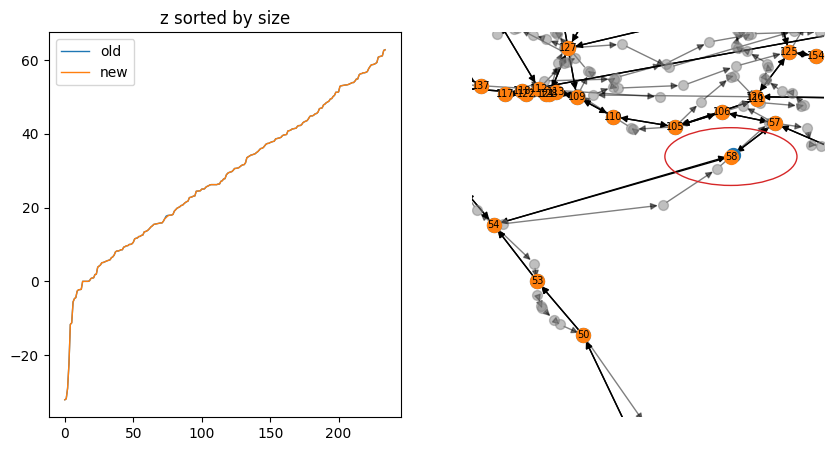

In [266]:
import pickle
from jaxley.io.graph import nx_to_pandas

fname = "morph_ca1_n120"
swc_graph = swc_to_nx(f"../jaxley/tests/swc_files/{fname}.swc")
comp_graph = build_compartment_graph(swc_graph, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph = _add_jaxley_meta_data(comp_graph)

with open(f"{fname}_comp_graph_w_comp_and_branch_index.pkl", "rb") as f:
    jx_comp_graph = pickle.load(f)

jx_nodes_df, jx_edges_df, jx_global_attrs = nx_to_pandas(jx_comp_graph)


# ----------
key = "z"
nx_nodes_df = nx_to_pandas(comp_graph)[0]
nx_vals = nx_nodes_df[key]
jx_vals = jx_nodes_df[key]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(jx_vals.sort_values().values, label="old", lw=1)
ax[0].plot(nx_vals.sort_values().values, label="new", lw=1)
ax[0].set_title(f"{key} sorted by size")
ax[0].legend()
# plt.xlim(0,120)
# plt.ylim(0.2,0.6)

is_close = np.isclose(jx_vals.values[:, None], nx_vals.values, atol=1e-10)

print("old")
print(jx_nodes_df.loc[~is_close.any(axis=1), ["length", "radius", "x", "y", "z", "groups"]], "\n\n")
print("new")
print(nx_nodes_df.loc[~is_close.any(axis=0), ["length", "radius", "x", "y", "z", "soma", "basal", "apical"]])

# ----------

swc_coords = {k: (v["x"], v["y"]) for k, v in swc_graph.nodes.items()}
nx_coords = {k: (v["x"], v["y"]) for k, v in comp_graph.nodes.items()}
jx_coords = {k: (v["x"], v["y"]) for k, v in jx_comp_graph.nodes.items()}

# colors = [comp_graph.nodes[n].get("soma", False) for n in comp_graph.nodes]

nx.draw(swc_graph, pos=swc_coords, with_labels=False, node_size=50, ax=ax[1], font_size=7, node_color="grey", alpha=0.5)
nx.draw(jx_comp_graph, pos=jx_coords, with_labels=False, node_size=100, ax=ax[1], font_size=7, node_color="tab:blue")
nx.draw(comp_graph, pos=nx_coords, with_labels=True, node_size=100, ax=ax[1], font_size=7, node_color="tab:orange")

for i in nx_nodes_df.index[~is_close.any(axis=0)]:
    circle = plt.Circle((nx_coords[i][0], nx_coords[i][1]), 3, color="tab:red", fill=False)
    ax[1].add_artist(circle)

ax[1].set_ylim(-20,20)
ax[1].set_xlim(-1,15)

In [320]:
import numpy as np
import matplotlib.pyplot as plt

def trapz(xp: np.ndarray, fp: np.ndarray, x1: float = None, x2: float = None) -> float:
    """Trapezoidally integrate a function between two points.
    
    Args:
        xp: The x-values of the function.
        fp: The y-values of the function.
        x1: The lower bound of the integration.
        x2: The upper bound of the integration.

    Returns:
        The integral of the function between x1 and x2.
    """
    # Find indices for the segment [x1, x2]
    x1 = xp[0] if x1 is None else x1
    x2 = xp[-1] if x2 is None else x2
    mask = (xp >= x1) & (xp <= x2)
    x_seg = xp[mask]
    fp_seg = fp[mask]

    # Add boundary points if needed
    if x1 not in x_seg:
        r1 = np.interp(x1, xp, fp)
        x_seg = np.insert(x_seg, 0, x1)
        fp_seg = np.insert(fp_seg, 0, r1)

    if x2 not in x_seg:
        r2 = np.interp(x2, xp, fp)
        x_seg = np.append(x_seg, x2)
        fp_seg = np.append(fp_seg, r2)

    # Trapezoidal integration
    integral = np.trapezoid(fp_seg, x_seg)

    return integral

def solid_of_revolution_properties(ls: np.ndarray, rs: np.ndarray, l_start: float = None, l_end: float = None) -> dict:
    """
    Calculate properties of a solid of revolution given length and radius coordinates.
    
    Args:
        ls: array of length coordinates along the path
        rs: array of radius coordinates
        l_start: optional start position for integration (default: min(ls))
        l_end: optional end position for integration (default: max(ls))
    
    Returns:
        dict: Dictionary containing surface_area, volume, and average_radius
    """
    if len(ls) != len(rs):
        raise ValueError("ls and rs must have the same length")
    
    # Set integration bounds
    l_start = ls[0] if l_start is None else l_start
    l_end = ls[-1] if l_end is None else l_end
    
    # Calculate derivatives dr/dl for surface area calculation
    # Use central differences where possible, forward/backward at endpoints
    dr_dl = np.zeros_like(rs)
    
    # Forward difference at start
    dr_dl[0] = (rs[1] - rs[0]) / (ls[1] - ls[0]) if len(rs) > 1 else 0
    
    # Central differences in middle
    for i in range(1, len(rs) - 1):
        dr_dl[i] = (rs[i+1] - rs[i-1]) / (ls[i+1] - ls[i-1])
    
    # Backward difference at end
    if len(rs) > 1:
        dr_dl[-1] = (rs[-1] - rs[-2]) / (ls[-1] - ls[-2])
    
    # a) Surface Area: SA = 2π ∫ r * sqrt(1 + (dr/dl)²) dl
    surface_integrand = 2 * np.pi * rs * np.sqrt(1 + dr_dl**2)
    surface_area = trapz(ls, surface_integrand, l_start, l_end)
    
    # b) Volume: V = π ∫ r² dl
    volume_integrand = np.pi * rs**2
    volume = trapz(ls, volume_integrand, l_start, l_end)
    
    # c) Average Radius: r_avg = ∫ r dl / ∫ dl = ∫ r dl / L
    # where L is the integration length
    radius_integrand = rs
    integration_length = l_end - l_start
    average_radius = trapz(ls, radius_integrand, l_start, l_end) / integration_length
    
    return {
        'area': surface_area,
        'volume': volume,
        'radius': average_radius,
    }

def plot_solid_profile(ls, rs, title="Solid of Revolution Profile"):
    """
    Plot the profile of the solid of revolution.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the profile
    ax1.plot(ls, rs, 'b-o', linewidth=2, markersize=4)
    ax1.fill_between(ls, 0, rs, alpha=0.3)
    ax1.set_xlabel('Length (l)')
    ax1.set_ylabel('Radius (r)')
    ax1.set_title('Profile View')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # Plot the revolution visualization (cross-section)
    theta = np.linspace(0, 2*np.pi, 100)
    max_r = max(rs)
    
    # Show a few cross-sections
    colors = ['red', 'green', 'blue', 'orange']
    for i, (l, r) in enumerate(zip(ls[::len(ls)//4], rs[::len(rs)//4])):
        if i < len(colors):
            x_circle = r * np.cos(theta)
            y_circle = r * np.sin(theta)
            ax2.plot(x_circle, y_circle, color=colors[i], alpha=0.7, 
                    label=f'l={l:.2f}')
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Cross-sections at Different Lengths')
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
# Example 1: Cone (radius decreases linearly)
print("Example 1: Cone")
ls_cone = [0, 1, 2, 3, 4, 5]
rs_cone = [2, 1.6, 1.2, 0.8, 0.4, 0]

results_cone = solid_of_revolution_properties(ls_cone, rs_cone)
print(f"Surface Area: {results_cone['surface_area']:.4f}")
print(f"Volume: {results_cone['volume']:.4f}")
print(f"Average Radius: {results_cone['average_radius']:.4f}")
print(f"Integration Length: {results_cone['integration_length']:.4f}")

# Example 2: Sphere (using half-circle approximation)
print("\nExample 2: Sphere approximation")
n_points = 10
ls_sphere = np.linspace(0, np.pi, n_points)
rs_sphere = np.sin(ls_sphere)  # Unit sphere

results_sphere = solid_of_revolution_properties(ls_sphere, rs_sphere)
print(f"Surface Area: {results_sphere['surface_area']:.4f} (theoretical: {4*np.pi:.4f})")
print(f"Volume: {results_sphere['volume']:.4f} (theoretical: {4*np.pi/3:.4f})")
print(f"Average Radius: {results_sphere['average_radius']:.4f}")

# Example 3: Parabolic shape
print("\nExample 3: Parabolic solid")
ls_parabola = np.linspace(0, 2, 11)
rs_parabola = 1 + 0.5 * ls_parabola**2

results_parabola = solid_of_revolution_properties(ls_parabola, rs_parabola)
print(f"Surface Area: {results_parabola['surface_area']:.4f}")
print(f"Volume: {results_parabola['volume']:.4f}")
print(f"Average Radius: {results_parabola['average_radius']:.4f}")

# Example 4: Partial integration (only part of the parabolic solid)
print("\nExample 4: Partial integration of parabolic solid (l=0.5 to l=1.5)")
results_partial = solid_of_revolution_properties(ls_parabola, rs_parabola, 0.5, 1.5)
print(f"Surface Area: {results_partial['surface_area']:.4f}")
print(f"Volume: {results_partial['volume']:.4f}")
print(f"Average Radius: {results_partial['average_radius']:.4f}")
print(f"Integration bounds: [{results_partial['l_start']:.1f}, {results_partial['l_end']:.1f}]")

# Uncomment to show plots
# plot_solid_profile(ls_cone, rs_cone, "Cone Profile")
# plot_solid_profile(ls_sphere, rs_sphere, "Sphere Profile")
# plot_solid_profile(ls_parabola, rs_parabola, "Parabolic Solid Profile")

Example 1: Cone
Surface Area: 33.8360
Volume: 21.3628
Average Radius: 1.0000
Integration Length: 5.0000

Example 2: Sphere approximation
Surface Area: 14.1769 (theoretical: 12.5664)
Volume: 4.9348 (theoretical: 4.1888)
Average Radius: 0.6301

Example 3: Parabolic solid
Surface Area: 33.8091
Volume: 19.8129
Average Radius: 1.6700

Example 4: Partial integration of parabolic solid (l=0.5 to l=1.5)
Surface Area: 14.2834
Volume: 7.7881
Average Radius: 1.5450
Integration bounds: [0.5, 1.5]


In [339]:
# branch_of = lambda n: solve_graph.nodes[n]["branch_index"]
# is_inter_branch_edge = lambda i, j: solve_graph.edges[i, j]["comp_edge"] and branch_of(i) != branch_of(j)
# branch_edges = [(branch_of(i), branch_of(j)) for (i,j) in solve_graph.edges if is_inter_branch_edge(i, j)]
# branch_graph = nx.DiGraph(branch_edges)

# acc_parents_per_cell = []
# for branches_per_cell in nx.weakly_connected_components(branch_graph):
#     cell_subgraph = branch_graph.subgraph(branches_per_cell)
#     root = next(n for n in cell_subgraph.nodes() if cell_subgraph.in_degree(n) == 0) # assumes each cell has only one root
#     nodes = [root] + [n for n in cell_subgraph.nodes() if n != root]
#     idx = {n: i for i, n in enumerate(nodes)}
#     acc_parents_per_cell += [[idx[next(cell_subgraph.predecessors(n))] if n != root else -1 for n in nodes]]
# acc_parents_per_cell

In [59]:
# # def to_graph(module: jx.Module) -> nx.DiGraph:
# nodes_df = cell.nodes
# synapse_edges = cell.edges
# # edges_df = cell.edges.set_index(["pre_index", "post_index"])
# global_attrs = {"channels": cell.channels, "group_names": cell.group_names, "synapses": cell.synapses, "xyzr": cell.xyzr}

# edges = cell._comp_edges.copy()
# condition1 = edges["type"].isin([2, 3])
# condition2 = edges["type"] == 0
# condition3 = edges["source"] < edges["sink"]
# edges = edges[condition1 | (condition3 & condition2)]
# edges = edges[["source", "sink"]].set_index(["source", "sink"])
# edges.index.names = [None, None]
# edges

In [123]:
# comp_index has to increase along branch, i.e. with node index
# Q1.
#   Should branchpoints have a comp_index?
    # not clear
#   Should comp_index be continuous across the entire module i.e. [0,1,2], [3,4,5] vs [0,1,2], [4,5,6]?
#   Should node_index be continuous across the entire module i.e. [0,1,2], [3,4,5] vs [0,1,2], [4,5,6]?
    # not needed (if loc can be made to work along branch correctly)
# Q2. 
#   Should the nodes (and hence the graph nodes) be ordered somehow, i.e. in depth-first order of the comp edges? Or should the comp_index be the index of the nodes_df?
    # ordering can be determined by ordering of comp_edges
# Q3.
#   Should the comp_index be the index of the nodes_df?
    # no

# Q4. How is solve order determined?
    # solve order is not determined in the reader and just adds a solve index to the nodes_df
# Q5. Is it fine to select relevant_ids in swc_to_nx? Or do we only want to ignore it for branch tracing and give option to add a group still?
    # - [4,4,4,4,2,4,4,4] has to produce 1 branch!
# Q6. keep x,y,z in nodes?
    # needs to be the same as compute_xyz



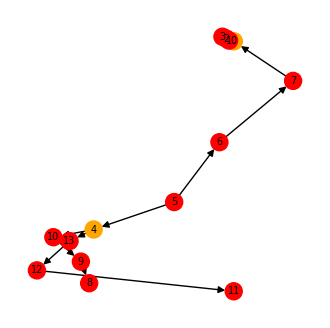

In [138]:
vis_compartment_graph(comp_graph)

In [139]:
comp_graph = _determine_solve_order(comp_graph, source=5)
solve_graph = _replace_branchpoints_with_edges(comp_graph)


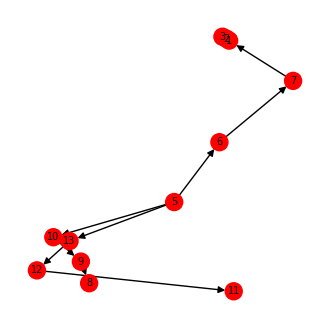

In [140]:
vis_compartment_graph(solve_graph)

In [356]:
from jaxley.io.swc import read_swc as jx_read_swc
from time import perf_counter

testcases = [ 
"morph_3_types.swc",
"morph_interrupted_soma.swc",
"morph_soma_both_ends.swc",
"morph_somatic_branchpoint.swc",
"morph_non_somatic_branchpoint.swc", # no soma!
"morph_ca1_n120.swc",
"morph_l5pc_with_axon.swc",
"morph_3_types_single_point_soma.swc",
"morph_ca1_n120_single_point_soma.swc",
"morph_allen_485574832.swc",
]

for testcase in testcases:
    start = perf_counter()
    jx_cell = jx_read_swc(f"../jaxley/tests/swc_files/{testcase}", ncomp=1)
    end = perf_counter()
    jx_time = end - start
    start = perf_counter()
    new_cell = read_swc(f"../jaxley/tests/swc_files/{testcase}", ncomp=1)
    end = perf_counter()
    new_time = end - start
    print(f"{testcase}: old={new_time:.3f}s | new={jx_time:.3f}s | new is {jx_time/new_time:.1f}x faster")

morph_3_types.swc: old=0.103s | new=0.111s | new is 1.1x faster
morph_interrupted_soma.swc: old=0.100s | new=0.098s | new is 1.0x faster
morph_soma_both_ends.swc: old=0.103s | new=0.107s | new is 1.0x faster
morph_somatic_branchpoint.swc: old=0.103s | new=0.108s | new is 1.0x faster


KeyboardInterrupt: 